## Implementing CNN from scratch JAN 28

### Import Library and Defining functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from patchify import patchify
from tensorflow.keras.optimizers import Adam
import skimage.io
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


seed=42
np.random.seed(seed)
tf.random.set_seed(seed)

os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32
    y_pred = K.cast(y_pred, 'float32')  # Ensure y_pred is float32

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

#CLAHE
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized


### Define load_images for Kaggle Train/Test Data

In [2]:
def load_images(image_dir, img_size=(1400, 875)):
    images = []

    image_files = sorted(os.listdir(image_dir))  # Ensure matching order with masks

    for img_file in image_files:
        # Load and preprocess the image
        img_path = os.path.join(image_dir, img_file)
        img = load_img(img_path, target_size=img_size)  # Resize image
        img = img_to_array(img) / 255.0  # Normalize image
        images.append(img)
        #plt.imshow(ing)
        #plt.axis("off")
        #plt.show()

    return np.array(images)


In [3]:
# Applying transformations on Kaggle data to make it similar to training data

def load_images_transform(image_dir, img_size=(1400, 875)):
    images = []

    image_files = sorted(os.listdir(image_dir))  # Ensure matching order with masks

    for img_file in image_files:
        # Load and preprocess the image
        img_path = os.path.join(image_dir, img_file)
        img = load_img(img_path, target_size=img_size)  # Resize image
        img = img_to_array(img) / 255.0  # Normalize image
        images.append(img)
        #plt.imshow(ing)
        #plt.axis("off")
        #plt.show()

    return np.array(images)


### Perform EDA on External dataser

In [4]:
file_path = "LeafDataset/LVD2021Extracted/LVD2021/9_VirginiaCreeper_labels/all/9_99/99_0003_背景.jpg"
try:
    img = Image.open(file_path)
    print("Image loaded successfully!")
    img_array = np.array(img) / 255.0
    print(img_array)
    print("Break")
except Exception as e:
    print(f"Error loading image: {e}")

# View pixels values
#image_read = cv2.imread(r"file_path", cv2.IMREAD_COLOR)
#print(image_read) 

Image loaded successfully!
[[[0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]
  ...
  [0.78431373 0.78823529 0.79607843]
  [0.78431373 0.78823529 0.79607843]
  [0.78431373 0.78823529 0.79607843]]

 [[0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]
  ...
  [0.78431373 0.78823529 0.79607843]
  [0.78431373 0.78823529 0.79607843]
  [0.78431373 0.78823529 0.79607843]]

 [[0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]
  [0.83137255 0.83137255 0.82352941]
  ...
  [0.78431373 0.78823529 0.79607843]
  [0.78431373 0.78823529 0.79607843]
  [0.78431373 0.78823529 0.79607843]]

 ...

 [[0.85882353 0.8627451  0.87058824]
  [0.85882353 0.8627451  0.87058824]
  [0.85882353 0.8627451  0.87058824]
  ...
  [0.83529412 0.83921569 0.85490196]
  [0.83529412 0.83921569 0.85490196]
  [0.83529412 0.83921569 0.85490196]]

 [[0.85882353 0.8627451  0.87058824]
  [0.85882

### Load external Images

In [5]:
def load_dataset(root_dir, image_suffix="_背景.jpg", mask_suffix="_图层 3.jpg"):

    images = []
    masks = []
    image_paths = []
    mask_paths = []
    count=640;  # Only load n number of images due to space limit of np.array

    # Iterate over top-level directories (1_Walnut_labels to 36_Holly_label)
    for label_dir in os.listdir(root_dir):
        label_path = os.path.normpath(os.path.join(root_dir, label_dir))
        print("root")
        # Check if it's a directory and matches the naming convention
        if os.path.isdir(label_path) and label_dir.endswith("_labels"):
            all_folder = os.path.normpath(os.path.join(label_path, "all"))
            print("all")
            # Check if the "all" folder exists
            if os.path.exists(all_folder):
                for subdir in os.listdir(all_folder):
                    #subdir_path = os.path.join(all_folder, subdir)
                    subdir_path = os.path.normpath(os.path.join(all_folder, subdir))
                    print(subdir_path)
                    #subdir_path=subdir_path.replace
                    # Ensure it's a directory (e.g., 1_1, 1_2, etc.)
                    if os.path.isdir(subdir_path):
                        # Collect images and masks from the subdirectory
                        
                        image_files = [f for f in os.listdir(subdir_path) if f.endswith(image_suffix)]
                        mask_files = [f for f in os.listdir(subdir_path) if f.endswith(mask_suffix)]
                        print(image_files)
                        print(mask_files)

                        for image_file in image_files:
                            for mask in mask_files:

                                print(image_file)
                                image_path = os.path.normpath(os.path.join(subdir_path, image_file))
                                mask_path = os.path.normpath(os.path.join(subdir_path, mask))


                                image = skimage.io.imread(image_path)  #Read image
                                image = image[:,:,1] #selecting green channel
                                image = clahe_equalized(image) #applying CLAHE
                                #SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
                                #SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
                                image = Image.fromarray(image)        
                                image = image.resize((512, 512)) #resize image     
                                image = np.array(image) 
                                #patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
                                image = (image.astype('float32')) / 255.
                                images.append(image)
                                
                                # Load both images
                                image_read = Image.open(image_path)
                                mask_read = Image.open(mask_path)
                                
                                # Resize to for model input
                                image_read =image_read.resize((1024,1024))
                                mask_read =mask_read.resize((1024,1024))
                                image_np = np.array(image_read)

                                # Define the threshold for white to change the background from white to black
                                threshold = 150  # 255 is pure white; lower values for off-white backgrounds

                                # Create a mask for white pixels
                                white_mask = (image_np[:, :, :3] >= threshold).all(axis=-1)

                                # Change white pixels to black but setting pixel value to 0
                                image_np[white_mask] = [0, 0, 0]

                                mask_np = np.array(mask_read)
                                
                                # Invert the mask: change 0 to 255 (black to white) and 255 to 0 (white to black) to match kaggle dataset
                                inverted_mask_np = 255 - mask_np
                                
                                # Rescale the pixels to 0,1
                                image_read = np.array(image_np) /255.0
                                mask_read = np.array(inverted_mask_np) / 255.0
                                
                                mask_read = (mask_read > 0).astype(np.float32)

                                mask_read= np.mean(mask_read,axis=-1)
                                mask_read = np.expand_dims(mask_read, axis=-1)  
                                print(mask_read.shape)
                                
                                # Append to lists
                                images.append(image_read)
                                masks.append(mask_read)
                                count-=1;
                                print(count)
                                if(count==0):
                                    return np.array(images), np.array(masks), image_paths, mask_paths

    return np.array(images), np.array(masks), image_paths, mask_paths

# Example usage
root_directory = "LeafDataset/LVD2021Extracted/LVD2021"
images_ex, masks_ex, image_paths, mask_paths = load_dataset(root_directory)

print(f"Loaded {len(images_ex)} image-mask pairs.")


root
all
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_1
['1_0004_背景.jpg']
['1_0001_图层 3.jpg']
1_0004_背景.jpg
(1024, 1024, 1)
639
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_10
['10_0004_背景.jpg']
['10_0001_图层 3.jpg']
10_0004_背景.jpg
(1024, 1024, 1)
638
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_100
['100_0004_背景.jpg']
['100_0001_图层 3.jpg']
100_0004_背景.jpg
(1024, 1024, 1)
637
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_101
['101_0004_背景.jpg']
['101_0001_图层 3.jpg']
101_0004_背景.jpg
(1024, 1024, 1)
636
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_102
['102_0004_背景.jpg']
['102_0001_图层 3.jpg']
102_0004_背景.jpg
(1024, 1024, 1)
635
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_103
['103_0004_背景.jpg']
['103_0001_图层 3.jpg']
103_0004_背景.jpg
(1024, 1024, 1)
634
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_104
['1

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1280,) + inhomogeneous part.

#### New Implementation

In [5]:
def load_dataset(root_dir, image_suffix="_背景.jpg", mask_suffix="_图层 3.jpg"):

    images = []
    masks = []
    image_paths = []
    mask_paths = []
    count=1500;  # Only load n number of images due to space limit of np.array

    # Iterate over top-level directories (1_Walnut_labels to 36_Holly_label)
    for label_dir in os.listdir(root_dir):
        label_path = os.path.normpath(os.path.join(root_dir, label_dir))
        print("root")
        # Check if it's a directory and matches the naming convention
        if os.path.isdir(label_path) and label_dir.endswith("_labels"):
            all_folder = os.path.normpath(os.path.join(label_path, "all"))
            print("all")
            # Check if the "all" folder exists
            if os.path.exists(all_folder):
                for subdir in os.listdir(all_folder):
                    #subdir_path = os.path.join(all_folder, subdir)
                    subdir_path = os.path.normpath(os.path.join(all_folder, subdir))
                    print(subdir_path)
                    #subdir_path=subdir_path.replace
                    # Ensure it's a directory (e.g., 1_1, 1_2, etc.)
                    if os.path.isdir(subdir_path):
                        # Collect images and masks from the subdirectory
                        
                        image_files = [f for f in os.listdir(subdir_path) if f.endswith(image_suffix)]
                        mask_files = [f for f in os.listdir(subdir_path) if f.endswith(mask_suffix)]
                        print(image_files)
                        print(mask_files)

                        for image_file in image_files:
                            for mask in mask_files:

                                print(image_file)
                                image_path = os.path.normpath(os.path.join(subdir_path, image_file))
                                mask_path = os.path.normpath(os.path.join(subdir_path, mask))

                                image = skimage.io.imread(image_path)

                                # Convert to grayscale if the image has multiple channels
                                if len(image.shape) == 3:  # If the image is RGB
                                    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

                                # Apply Otsu's thresholding to segment the leaf
                                _, mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                                # Ensure that the **leaf is white** (foreground) and **background is black**
                                mask = cv2.bitwise_not(mask)  # Invert the mask so that the leaf remains white

                                # Extract the leaf using the mask
                                leaf = cv2.bitwise_and(image, image, mask=mask)

                                # Create a black background
                                result = np.zeros_like(image)  
                                result[mask > 0] = leaf[mask > 0]  # Keep only the leaf pixels, set the rest to black

                                # Convert to PIL image and resize
                                image = Image.fromarray(result)
                                image = image.resize((512, 512))  # Resize image
                                image = np.array(image)

                                # Normalize image to range [0,1]
                                image = (image.astype('float32')) / 255.

                                # Append to dataset
                                images.append(image)
                                
                                mask = skimage.io.imread(mask_path)  #Read image
                                mask = mask[:,:,1] #selecting green channel
                                mask = clahe_equalized(mask) #applying CLAHE
                                #SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
                                #SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
                                mask = Image.fromarray(mask)        
                                mask = mask.resize((512, 512)) #resize image     
                                mask = np.array(mask) 
                                #patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
                                mask = (mask.astype('float32')) / 255.
                                masks.append(mask)
                                
                                count-=1;
                                print(count)
                                if(count==0):
                                    return np.array(images), np.array(masks), image_paths, mask_paths

    return np.array(images), np.array(masks), image_paths, mask_paths

# Example usage
root_directory = "LeafDataset/LVD2021Extracted/LVD2021"
ResNet_images, ResNet_masks, image_paths, mask_paths = load_dataset(root_directory)

print(f"Loaded {len(ResNet_images)} image-mask pairs.")


root
all
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_1
['1_0004_背景.jpg']
['1_0001_图层 3.jpg']
1_0004_背景.jpg
1499
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_10
['10_0004_背景.jpg']
['10_0001_图层 3.jpg']
10_0004_背景.jpg
1498
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_100
['100_0004_背景.jpg']
['100_0001_图层 3.jpg']
100_0004_背景.jpg
1497
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_101
['101_0004_背景.jpg']
['101_0001_图层 3.jpg']
101_0004_背景.jpg
1496
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_102
['102_0004_背景.jpg']
['102_0001_图层 3.jpg']
102_0004_背景.jpg
1495
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_103
['103_0004_背景.jpg']
['103_0001_图层 3.jpg']
103_0004_背景.jpg
1494
LeafDataset\LVD2021Extracted\LVD2021\10_ForsythiaSuspensa_labels\all\10_104
['104_0004_背景.jpg']
['104_0001_图层 3.jpg']
104_0004_背景.jpg
1493
LeafDataset\LVD2021Extracted\L

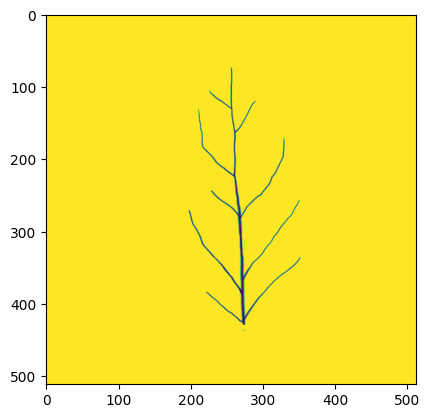

In [6]:
#View the loaded external images
plt.imshow(ResNet_images[0])
plt.imshow(ResNet_masks[1])
plt.show()


### Loading the Kaggle train files

Loaded 17 images
Image shape: (512, 512, 3)
17


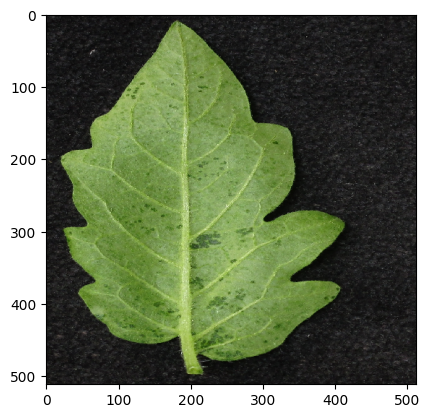

In [7]:
#image_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train"
image_dir = "infected-tomato-leaf-vein-segmentation/train"

img_size = (512, 512)  # Input size for U-Net

images_kaggle = load_images(image_dir, img_size)

print(f"Loaded {len(images_kaggle)} images")
print(f"Image shape: {images_kaggle[0].shape}")
print(len(images_kaggle))

plt.imshow(images_kaggle[16])
plt.show()


### Decode the training mask data and displaying it

(17, 512, 512, 1)


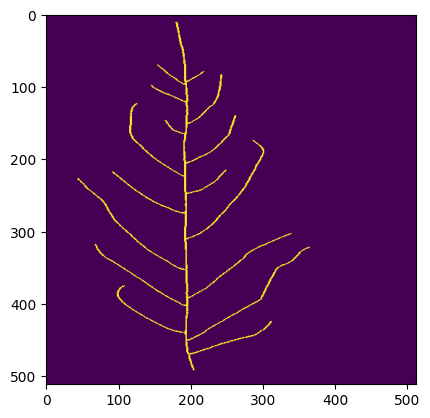

In [8]:

HEIGHT = 1400
WIDTH = 875

#mask_read=pd.read_csv("drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/train.csv")
mask_read=pd.read_csv("infected-tomato-leaf-vein-segmentation/train.csv")

mask=mask_read['annotation']

def rl_decode(enc):
    parts = [int(s) for s in enc.split(' ')]
    dec = list()
    for i in range(0, len(parts), 2):
        cnt = parts[i]
        val = parts[i+1]
        dec += cnt * [val]
    return np.array(dec, dtype=np.uint8).reshape((HEIGHT, WIDTH))

decoded_masks=[]

for item in mask:
    np_mask=rl_decode(item)
    np_mask_resize=cv2.resize(np_mask,(512,512))
    np_mask_resize=np_mask_resize[:,:]
    decoded_masks.append(np_mask_resize)

decoded_masks=np.array(decoded_masks,dtype=np.float32)
decoded_masks = np.expand_dims(decoded_masks,axis=-1)


print(decoded_masks.shape)

plt.imshow(decoded_masks[16])
plt.show()


##### Loading Data Techinque using single channel and patches

(17, 512, 512, 1)


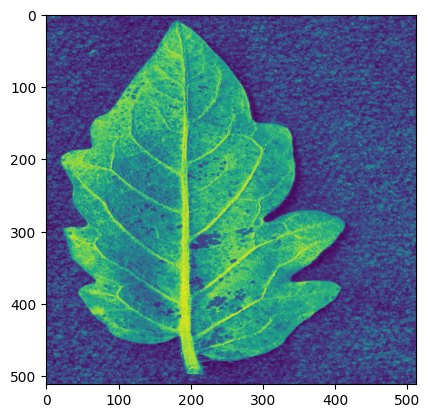

(10, 512, 512, 1)


In [9]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image

#CLAHE
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized

path1 = 'infected-tomato-leaf-vein-segmentation/train' #training images directory
path2 = 'infected-tomato-leaf-vein-segmentation/test' #training masks directory

image_dataset = []
test_image_dataset=[]
patch_size = 1024

images = sorted(os.listdir(path1)) 
for i, image_name in enumerate(images):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path1+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
       image = clahe_equalized(image) #applying CLAHE
       
       #SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
       #SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image     
       
       image = np.array(image) 
       #patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
       image = (image.astype('float32')) / 255.
       image_dataset.append(image)
            
       #for i in range(patches_img.shape[0]):
        #   for j in range(patches_img.shape[1]):                        
         #      single_patch_img = patches_img[i,j,:,:]                 
         #      single_patch_img = (single_patch_img.astype('float32')) / 255.                    
         #      image_dataset.append(image)

image_dataset = np.array(image_dataset)
image_dataset = np.expand_dims(image_dataset,axis=-1)
print(image_dataset.shape)

plt.imshow(image_dataset[16])
plt.show()


images = sorted(os.listdir(path2)) 
for i, image_name in enumerate(images):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path2+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
       image = clahe_equalized(image) #applying CLAHE
       
       #SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
       #SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image     
       
       image = np.array(image) 
       #patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
       image = (image.astype('float32')) / 255.
       test_image_dataset.append(image)
            
       #for i in range(patches_img.shape[0]):
        #   for j in range(patches_img.shape[1]):                        
         #      single_patch_img = patches_img[i,j,:,:]                 
         #      single_patch_img = (single_patch_img.astype('float32')) / 255.                    
         #      image_dataset.append(image)

test_image_dataset = np.array(test_image_dataset)
test_image_dataset = np.expand_dims(test_image_dataset,axis=-1)
print(test_image_dataset.shape)







#save model
#model.save('/content/drive/MyDrive/training/retina_Unet_150epochs.hdf5')

(10, 512, 512, 1)


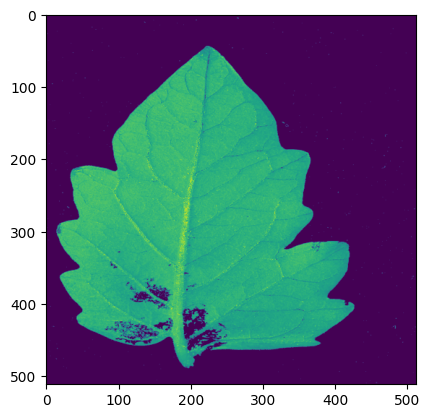

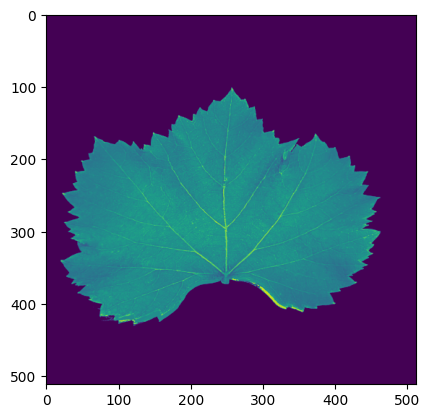

In [45]:
# Processing test images

path1_for_testimage = 'infected-tomato-leaf-vein-segmentation/test' #training images directory


image_dataset_testimage = []
patch_size = 1024

images = sorted(os.listdir(path1_for_testimage)) 
for i, image_name in enumerate(images):  
   if image_name.endswith(".jpg"):                   
        image = skimage.io.imread(path1_for_testimage + "/" + image_name)  # Read image
        # Convert to grayscale if image is RGB
        if len(image.shape) == 3:  # Check if the image has multiple channels
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
        else:
            gray = image  # Already grayscale
        
        # Apply Otsu's Thresholding to automatically detect the leaf
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Invert the mask so that the leaf is white and background is black
        mask_inv = cv2.bitwise_not(mask)

        # Extract only the leaf from the original image
        leaf = cv2.bitwise_and(image, image, mask=mask)

        # Create a pure black background
        result = np.zeros_like(image)  # Black background
        result[mask == 255] = leaf[mask == 255]  # Keep only leaf pixels

        # Resize the image
        image = Image.fromarray(result)
        image = image.resize((512, 512))  # Resize image     
        image = np.array(image) 

        # Normalize and store
        image = (image.astype('float32')) / 255.
        image = image[:, :, 1]  # Selecting green channel
        #image = clahe_equalized(image) 
        image_dataset_testimage.append(image)
            
       #for i in range(patches_img.shape[0]):
        #   for j in range(patches_img.shape[1]):                        
         #      single_patch_img = patches_img[i,j,:,:]                 
         #      single_patch_img = (single_patch_img.astype('float32')) / 255.                    
         #      image_dataset.append(image)

image_dataset_testimage = np.array(image_dataset_testimage)
image_dataset_testimage = np.expand_dims(image_dataset_testimage,axis=-1)
print(image_dataset_testimage.shape)
image_dataset_testimage = np.squeeze(image_dataset_testimage, axis=-1)

plt.imshow(image_dataset_testimage[0])
plt.show()

plt.imshow(ResNet_images[299])
#plt.imshow(ResNet_masks[299])
plt.show()


### Split the data

In [11]:

X_train, X_val, y_train, y_val = train_test_split(ResNet_images,ResNet_masks, test_size=0.1, random_state=42)
X_trainF, X_valF, y_trainF, y_valF = train_test_split(image_dataset,decoded_masks, test_size=0.1, random_state=42)


### Building a model to train data on

In [12]:

#convolutional block
def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

#Simple U-NET
def unetmodel(input_shape, dropout=0.2, batchnorm=True):    
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2
    
    inputs = layers.Input(input_shape)    

    # Downsampling layers
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers


    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, dn_4], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, dn_3], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
       
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, dn_2], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, dn_1], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)    
   
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
        
    return model

input_shape = (512, 512, 1)
modelunet = unetmodel(input_shape)

modelunet.compile(optimizer = Adam(learning_rate=0.001), loss= IoU_loss, metrics= ['accuracy', IoU_coef])
modelunet.summary() 
    


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][

 Total params: 1,968,229 (7.51 MB)

 Trainable params: 1,965,283 (7.50 MB)

 Non-trainable params: 2,946 (11.51 KB)

#### Residual Network

In [13]:
#residual convolutional block
def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)    
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        #conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)
        
    #skip connection    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    #shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2]) 
    respath_final = layers.Activation("relu")(respath)      
    return respath_final


#Res-UNET
def residualunet(input_shape, dropout=0.2, batchnorm=True):

    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape) 

    # Downsampling layers    
    dn_conv1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    dn_pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv1)

    dn_conv2 = res_conv_block(dn_pool1, kernelsize, filters[1], dropout, batchnorm)
    dn_pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv2)

    dn_conv3 = res_conv_block(dn_pool2, kernelsize, filters[2], dropout, batchnorm)
    dn_pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv3)

    dn_conv4 = res_conv_block(dn_pool3, kernelsize, filters[3], dropout, batchnorm)
    dn_pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv4)

    dn_conv5 = res_conv_block(dn_pool4, kernelsize, filters[4], dropout, batchnorm)
   
    # upsampling layers
    up_conv6 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_conv5)
    up_conv6 = layers.concatenate([up_conv6, dn_conv4], axis=3)
    up_conv6 = res_conv_block(up_conv6, kernelsize, filters[3], dropout, batchnorm)

    up_conv7 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv6)
    up_conv7 = layers.concatenate([up_conv7, dn_conv3], axis=3)
    up_conv7 = res_conv_block(up_conv7, kernelsize, filters[2], dropout, batchnorm)

    up_conv8 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv7)
    up_conv8 = layers.concatenate([up_conv8, dn_conv2], axis=3)
    up_conv8 = res_conv_block(up_conv8, kernelsize, filters[1], dropout, batchnorm)

    up_conv9 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv8)
    up_conv9 = layers.concatenate([up_conv9, dn_conv1], axis=3)
    up_conv9 = res_conv_block(up_conv9, kernelsize, filters[0], dropout, batchnorm)


    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv9)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final) 
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model

input_shape = (512, 512, 1)
model = residualunet(input_shape)

model.compile(optimizer = Adam(learning_rate=0.001), loss= IoU_loss, metrics= ['accuracy', IoU_coef])
model.summary() 


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 512, 512,  │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 512, 512,  │          0 │ activation_23[0]… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 512, 512,  │      2,320 │ dropout_11[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 256, 256,  │          0 │ activation_24[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 256, 256,  │      9,248 │ activation_25[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 256, 256,  │        544 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256, 256,  │          0 │ batch_normalizat

 Total params: 2,080,629 (7.94 MB)

 Trainable params: 2,076,243 (7.92 MB)

 Non-trainable params: 4,386 (17.13 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 512, 512,  │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 512, 512,  │          0 │ activation_23[0]… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 512, 512,  │      2,320 │ dropout_11[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 256, 256,  │          0 │ activation_24[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 256, 256,  │      9,248 │ activation_25[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 256, 256,  │        544 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256, 256,  │          0 │ batch_normalizat

 Total params: 2,080,629 (7.94 MB)

 Trainable params: 2,076,243 (7.92 MB)

 Non-trainable params: 4,386 (17.13 KB)

In [ ]:
def get_unet_1024(input_shape=(1024, 1024, 3), num_classes=1):


    
    inputs = Input(shape=input_shape)
    down0b = Conv2D(8, (3, 3), padding='same')(inputs)
    down0b = Activation('relu')(down0b)
    down0b = Conv2D(8, (3, 3), padding='same')(down0b)
    down0b = Activation('relu')(down0b)
    down0b_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0b)
    #512
    down0a = Conv2D(16, (3, 3), padding='same')(down0b_pool)
    down0a = Activation('relu')(down0a)
    down0a = Conv2D(16, (3, 3), padding='same')(down0a)
    down0a = Activation('relu')(down0a)
    down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)
    # 256
    down0 = Conv2D(32, (3, 3), padding='same')(down0a_pool)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    #64
    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    #32
    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 16
    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    #8
    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    #4
    down5 = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    down5 = Activation('relu')(down5)
    down5 = Conv2D(1024, (3, 3), padding='same')(down5)
    down5 = Activation('relu')(down5)
    down5_pool = MaxPooling2D((2, 2), strides=(2, 2))(down5)
    #2
    down6 = Conv2D(2048, (3, 3), padding='same')(down5_pool)
    down6 = Activation('relu')(down6)
    down6 = Conv2D(2048, (3, 3), padding='same')(down6)
    down6 = Activation('relu')(down6)
    down6_pool = MaxPooling2D((2, 2), strides=(2, 2))(down6)

    center = Conv2D(4096, (3, 3), padding='same')(down6_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(4096, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)

    up9 = UpSampling2D((2, 2))(center)
    up9 = concatenate([down6, up9], axis=3)
    up9 = Conv2D(2048, (3, 3), padding='same')(up9)
    up9 = Activation('relu')(up9)
    up9 = Conv2D(2048, (3, 3), padding='same')(up9)
    up9 = Activation('relu')(up9)

    up8 = UpSampling2D((2, 2))(up9)
    up8 = concatenate([down5, up8], axis=3)
    up8 = Conv2D(1024, (3, 3), padding='same')(up8)
    up8 = Activation('relu')(up8)
    up8 = Conv2D(1024, (3, 3), padding='same')(up8)
    up8 = Activation('relu')(up8)

    up7 = UpSampling2D((2, 2))(up8)
    up7 = concatenate([down4, up7], axis=3)
    up7 = Conv2D(512, (3, 3), padding='same')(up7)
    up7 = Activation('relu')(up7)
    up7 = Conv2D(512, (3, 3), padding='same')(up7)
    up7 = Activation('relu')(up7)


    up6 = UpSampling2D((2, 2))(up7)
    up6 = concatenate([down3, up6], axis=3)
    up6 = Conv2D(256, (3, 3), padding='same')(up6)
    up6 = Activation('relu')(up6)
    up6 = Conv2D(256, (3, 3), padding='same')(up6)
    up6 = Activation('relu')(up6)

    up5 = UpSampling2D((2, 2))(up6)
    up5 = concatenate([down2, up5], axis=3)
    up5 = Conv2D(128, (3, 3), padding='same')(up5)
    up5 = Activation('relu')(up5)
    up5 = Conv2D(128, (3, 3), padding='same')(up5)
    up5 = Activation('relu')(up5)

    up4 = UpSampling2D((2, 2))(up5)
    up4 = concatenate([down1, up4], axis=3)
    up4 = Conv2D(64, (3, 3), padding='same')(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(64, (3, 3), padding='same')(up4)
    up4 = Activation('relu')(up4)

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down0, up3], axis=3)
    up3 = Conv2D(32, (3, 3), padding='same')(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(32, (3, 3), padding='same')(up3)
    up3 = Activation('relu')(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down0a, up2], axis=3)
    up2 = Conv2D(16, (3, 3), padding='same')(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(16, (3, 3), padding='same')(up2)
    up2 = Activation('relu')(up2)

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down0b, up1], axis=3)
    up1 = Conv2D(8, (3, 3), padding='same')(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(8, (3, 3), padding='same')(up1)
    up1 = Activation('relu')(up1)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryIoU()])

    return model


input_shape = (1024, 1024, 1)
unet_model_new = get_unet_1024(input_shape)

unet_model_new.summary()
    

### Model Train Preparations 

In [13]:
class StopAndTestCallback(tf.keras.callbacks.Callback):
    def __init__(self, stop_epoch):
        super().__init__()
        self.stop_epoch = stop_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 == self.stop_epoch:
            print(f"\nStopping training at epoch {self.stop_epoch}")
            self.model.stop_training = True

### Training the model

In [14]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.weights.h5',  # Save path
    save_best_only=True,            # Save the model at every epoch
    save_weights_only=True           # Save weights instead of the full model
)
stop_epoch = 7
print(image_dataset.shape)
print(decoded_masks.shape)


#history= model.fit(image_dataset,decoded_masks,epochs=50,batch_size=2, verbose=1,callbacks=[checkpoint_callback,StopAndTestCallback(stop_epoch)])

history= modelunet.fit(X_train,y_train,epochs=25,batch_size=10, verbose=1,callbacks=[checkpoint_callback,StopAndTestCallback(stop_epoch)])

#history= modelunet.fit(ResNet_images,ResNet_masks,epochs=50,batch_size=2, verbose=1,callbacks=[checkpoint_callback,StopAndTestCallback(stop_epoch)])

(17, 512, 512, 1)
(17, 512, 512, 1)
Epoch 1/25


c:\Users\Shashwat\Desktop\US Applications\US\Internship\Machine Learning\Data Processing and Lib\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(10, 512, 512))
  warnings.warn(msg)


135/135 ━━━━━━━━━━━━━━━━━━━━ 974s 7s/step - accuracy: 0.7916 - io_u_coef: 0.5337 - loss: -0.5337
Epoch 2/25


c:\Users\Shashwat\Desktop\US Applications\US\Internship\Machine Learning\Data Processing and Lib\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 967s 7s/step - accuracy: 0.9005 - io_u_coef: 0.5829 - loss: -0.5829
Epoch 3/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 981s 7s/step - accuracy: 0.9152 - io_u_coef: 0.6206 - loss: -0.6206
Epoch 4/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 990s 7s/step - accuracy: 0.9235 - io_u_coef: 0.6550 - loss: -0.6550
Epoch 5/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1029s 8s/step - accuracy: 0.9303 - io_u_coef: 0.6864 - loss: -0.6864
Epoch 6/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1030s 8s/step - accuracy: 0.9356 - io_u_coef: 0.7148 - loss: -0.7148
Epoch 7/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9405 - io_u_coef: 0.7405 - loss: -0.7405
Stopping training at epoch 7
135/135 ━━━━━━━━━━━━━━━━━━━━ 1031s 8s/step - accuracy: 0.9405 - io_u_coef: 0.7405 - loss: -0.7405


### Save And/Or Load a model

In [16]:
# Save the entire model (architecture, weights, optimizer)
modelunet.save('unet_model_7.h5')  # You can use any name for the file


In [59]:
import tensorflow as tf

# Load the model from the .h5 file
modelF = tf.keras.models.load_model("unet_model_7.h5", compile=False)

# Print the model summary to verify it loaded correctly
modelF.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][

 Total params: 1,968,229 (7.51 MB)

 Trainable params: 1,965,283 (7.50 MB)

 Non-trainable params: 2,946 (11.51 KB)

In [47]:

image_dataset_testimage = np.squeeze(image_dataset_testimage, axis=-1)
image_dataset_testimage = np.squeeze(image_dataset_testimage, axis=-1)

(10, 512, 512)


ValueError: cannot select an axis to squeeze out which has size not equal to one

### Make Preditions on singular data

In [68]:

X_val = tf.expand_dims(X_val, axis=-1)  # Adds channel dimension
print(X_val.shape)
print(X_trainF.shape)

(150, 512, 512, 1)
(15, 512, 512, 1)


In [73]:

predictions = modelF.predict(X_valF)

print(predictions[0].shape)  # Should be (1, 875, 1400, 3) for a single image

reshaped_predictions = predictions[0][:, :, 0]  # Remove the batch and channel dimensions
np.savetxt('predictions.txt', reshaped_predictions)
thresholded_predictions = (predictions[0] > 0.5).astype(np.uint8)
print(thresholded_predictions.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
(512, 512, 1)
(512, 512, 1)


In [ ]:
#image_dir = "drive/MyDrive/Data/infected-tomato-leaf-vein-segmentation/single"
image_dir = "infected-tomato-leaf-vein-segmentation/single"
#image_dir = "LeafDataset/LVD2021Extracted/LVD2021/1_Walnut_labels/test/1_10"
#image_dir = "LeafDataset/LVD2021Extracted/LVD2021/5_ChineseRedbud_labels/test/5_8"
#image_dir = "LeafDataset/LVD2021Extracted/LVD2021/14_Hibiscus_labels/test/14_2"

img_size = (1024, 1024)  # Input size for U-Net
images_test = load_images(image_dir, img_size)

print(images_test.shape)  # Should be (1, 1024, 1024, 3) for a single image

predictions = unet_model_new.predict(images_test)

print(predictions[0].shape)  # Should be (1, 875, 1400, 3) for a single image

reshaped_predictions = predictions[0][:, :, 0]  # Remove the batch and channel dimensions
np.savetxt('predictions.txt', reshaped_predictions)

thresholded_predictions = (predictions[0] > 0.5).astype(np.uint8)

print(thresholded_predictions.shape)



### See the data

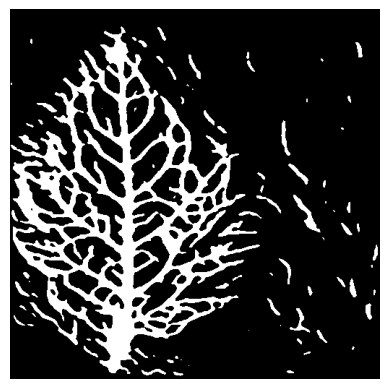

In [76]:
import matplotlib.pyplot as plt

# Convert predictions to binary (0 and 1)
thresholded_predictions = (predictions[1] > 0.5).astype(np.uint8)

# Invert values: Change 0 to 1 and 1 to 0
inverted_predictions = 1 - thresholded_predictions  

# Display the inverted binary mask
plt.imshow(inverted_predictions[:, :, 0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')  # Hide axis for cleaner display
plt.show()

### Apply Fine-Tuning by Fiting on Internal Data : Did not work

In [23]:
for layer in modelunet.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

modelunet.compile(optimizer = Adam(learning_rate=0.001), loss= IoU_loss, metrics= ['accuracy', IoU_coef])

history_fine_tune= modelunet.fit(X_trainF,y_trainF,epochs=7,batch_size=2, verbose=1,callbacks=[checkpoint_callback,StopAndTestCallback(stop_epoch)])



Epoch 1/7


c:\Users\Shashwat\Desktop\US Applications\US\Internship\Machine Learning\Data Processing and Lib\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 1))
  warnings.warn(msg)


8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2232 - io_u_coef: 0.0160 - loss: -0.0158
Epoch 2/7


c:\Users\Shashwat\Desktop\US Applications\US\Internship\Machine Learning\Data Processing and Lib\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5422 - io_u_coef: 0.0281 - loss: -0.0280
Epoch 3/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5682 - io_u_coef: 0.0287 - loss: -0.0286
Epoch 4/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5746 - io_u_coef: 0.0291 - loss: -0.0290
Epoch 5/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5839 - io_u_coef: 0.0294 - loss: -0.0293
Epoch 6/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5930 - io_u_coef: 0.0297 - loss: -0.0296
Epoch 7/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6119 - io_u_coef: 0.0300 - loss: -0.0300
Stopping training at epoch 7
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6132 - io_u_coef: 0.0300 - loss: -0.0299


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
(512, 512, 1)


TypeError: Invalid shape (2, 512, 512, 1) for image data

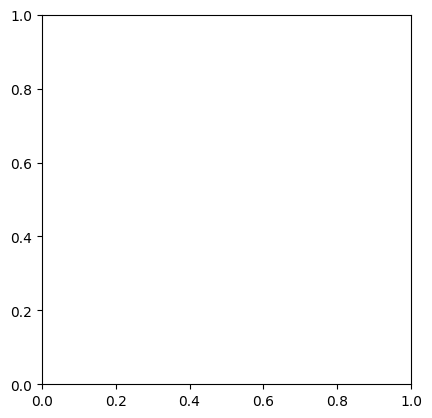

In [39]:
### Test the outcome 
predictionsF = modelunet.predict(X_valF)

print(predictionsF[0].shape)  # Should be (1, 875, 1400, 3) for a single image

import matplotlib.pyplot as plt

# Convert predictions to binary (0 and 1)
thresholded_predictions = (predictionsF[0] > 0.5).astype(np.uint8)

# Invert values: Change 0 to 1 and 1 to 0
inverted_predictions = 1 - thresholded_predictions  

# Display the inverted binary mask
plt.imshow(predictionsF, cmap='gray', vmin=0, vmax=1)
plt.axis('off')  # Hide axis for cleaner display
plt.show()


In [21]:
def run_length_encode(mask):
    # Flatten the 2D mask into a 1D array
    flat_mask = mask.flatten()
    # Initialize the result list to store the RLE encoding
    rle = []
    # Initialize the first character of the string and the count
    prev_char = flat_mask[0]
    count = 1
    # Iterate through the flattened mask starting from the second character
    for char in flat_mask[1:]:
        if char == prev_char:
            # If the character is the same as the previous one, increment the count
            count += 1
        else:
            # If the character changes, append the previous character's count and value to the result
            rle.append(count)
            rle.append(prev_char)
            # Reset the count for the new character
            prev_char = char
            count = 1
    # Append the last character's count and value
    rle.append(count)
    rle.append(prev_char)
    # Return the RLE encoded result as a space-separated string
    return ' '.join(map(str, rle))

In [21]:
submission_data=[]
test_folder = 'infected-tomato-leaf-vein-segmentation/test'
# Iterate through all images in the test folder
for image_name in os.listdir(test_folder):
    if image_name.endswith(('.jpg', '.png')):  # Only process image files
        img_path = os.path.join(test_folder, image_name)
        # Preprocess the image
        #img = preprocess_image(img_path)
        # Predict the mask using the model
        
        mask_prediction = modelunet.predict(image_dataset_testimage)  ## Update model name
        mask = mask_prediction[0, :, :, 0]
        inverted_predictions = 1 - thresholded_predictions # INVERT THE DATA
        mask_resized = cv2.resize(inverted_predictions, (875, 1400))
        # Since the output of the unet_model is a batch of masks, extract the first mask
        mask = (mask_resized> 0.5).astype(np.uint8)  # Binary mask, thresholding at 0.5
        reshaped_predictions = mask[:, :]  # Remove the batch and channel dimensions
        print(reshaped_predictions.shape)
        np.savetxt('predictions.txt', reshaped_predictions)

        # Apply RLE to the binary mask
        rle_encoded = run_length_encode(mask)

        # Append the result to the submission data
        image_id = image_name.split('.')[0]  # Extract the image ID without file extension
        submission_data.append([image_id, rle_encoded])

# Create a DataFrame for submission
submission_df = pd.DataFrame(submission_data, columns=['id', 'annotation'])

submission_df.to_csv('submissionNewSimpleUnet2000.csv', index=False)

print("Submission file created successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1400, 875)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1400, 875)
Submission file created successfully!


### Make final data submission

##### Flatten the data by Run-Length Encoding

In [ ]:
def run_length_encode(mask):
    # Flatten the 2D mask into a 1D array
    flat_mask = mask.flatten()
    # Initialize the result list to store the RLE encoding
    rle = []
    # Initialize the first character of the string and the count
    prev_char = flat_mask[0]
    count = 1
    # Iterate through the flattened mask starting from the second character
    for char in flat_mask[1:]:
        if char == prev_char:
            # If the character is the same as the previous one, increment the count
            count += 1
        else:
            # If the character changes, append the previous character's count and value to the result
            rle.append(count)
            rle.append(prev_char)
            # Reset the count for the new character
            prev_char = char
            count = 1
    # Append the last character's count and value
    rle.append(count)
    rle.append(prev_char)
    # Return the RLE encoded result as a space-separated string
    return ' '.join(map(str, rle))


# Function to preprocess the test image
def preprocess_image(img_path, target_size=(1024, 1024)):
    """Load and preprocess the image."""
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image
    return img

# Path to the test folder containing images
test_folder = 'infected-tomato-leaf-vein-segmentation/test'
# Prepare the submission dataframe
submission_data = []

# Iterate through all images in the test folder
for image_name in os.listdir(test_folder):
    if image_name.endswith(('.jpg', '.png')):  # Only process image files
        img_path = os.path.join(test_folder, image_name)
        # Preprocess the image
        img = preprocess_image(img_path)
        # Predict the mask using the model
        
        mask_prediction = old_model.predict(img)  ## Update model name
        mask = mask_prediction[0, :, :, 0]
        mask_resized = cv2.resize(mask, (875, 1400))
        # Since the output of the unet_model is a batch of masks, extract the first mask
        mask = (mask_resized> 0.5).astype(np.uint8)  # Binary mask, thresholding at 0.5
        reshaped_predictions = mask[:, :]  # Remove the batch and channel dimensions
        print(reshaped_predictions.shape)
        np.savetxt('predictions.txt', reshaped_predictions)

        # Apply RLE to the binary mask
        rle_encoded = run_length_encode(mask)

        # Append the result to the submission data
        image_id = image_name.split('.')[0]  # Extract the image ID without file extension
        submission_data.append([image_id, rle_encoded])

# Create a DataFrame for submission
submission_df = pd.DataFrame(submission_data, columns=['id', 'annotation'])

submission_df.to_csv('submissionNew.csv', index=False)

print("Submission file created successfully!")